## Sample generation
#### load trained model -> generate samples

In [12]:
IGNORE_NOTE_VELOCITY = True
TARGET_IS_SEQUENCE = True
MAX_WINDOW_SIZE = 100

import numpy as np
# from tensorflow import keras

INPUT_SIZE = 128 if IGNORE_NOTE_VELOCITY else 256
# [batch_size, sequence_len, input_dim]

input_path = 'D:\\Studia\\SEM6\\biai\\projekt\\pretrained_models\\'
input_file_name = 'beth_notransp_randchunk_bcr_512_32epochs_108.0m.h5'

# model = keras.models.load_model(input_path + input_file_name)

### Generate seed

In [185]:
import numpy as np
import random

# helpers
scales = {
    "natural_minor": [0, 2, 3, 5, 7, 8, 10, 12],
    "harmonic_minor": [0, 2, 3, 5, 7, 8, 11, 12],
    "melodic_minor": [0, 2, 3, 5, 7, 9, 11, 12],
    "major": [0, 2, 4, 5, 7, 9, 11, 12],
    "dorian": [0, 2, 4, 5, 7, 9, 10, 12],
    "mixolydian": [0, 2, 4, 5, 7, 9, 10, 12],
    "pentatonic": [0, 3, 5, 7, 10, 12],
}

def get_random_scale():
    return random.choice(list(scales.values()))

def get_random_notes_from_random_scale(base_note, n_notes=1):
    scale = get_random_scale()
    two_octave_scale = scale + [-x for x in scale]
    return [base_note + random.choice(two_octave_scale) for _ in range(n_notes)]

In [186]:
def random_noise_seed(length=MAX_WINDOW_SIZE, batch_size=16):
    return np.random.random((batch_size, length, INPUT_SIZE)) * 0.5

In [187]:
def zero_seed(length=MAX_WINDOW_SIZE, batch_size=16):
    return np.zeros((batch_size, length, INPUT_SIZE))

In [20]:
# notes in middle range have highier values
# taken from normal distribution for each "hand"
# mu1 = 76, mu2 = 48, std = 12
def random_normal_noise_seed(length=MAX_WINDOW_SIZE, batch_size=16):
    mu1 = 76
    mu2 = 48
    std = 12
    hand1 = np.exp(-(np.arange(128) - mu1) ** 2 / (2 * std ** 2))
    hand2 = np.exp(-(np.arange(128) - mu2) ** 2 / (2 * std ** 2))
    hands = hand1 + hand2
    randomness = np.random.random(((batch_size, length, INPUT_SIZE))) * 0.5
    return randomness * hands

In [192]:
def single_note_seed(length=MAX_WINDOW_SIZE, batch_size=16):
    res = np.zeros((batch_size, length, INPUT_SIZE))
    for i in range(batch_size):
        note = int(np.random.normal(72, 16))
        res[i, :, note] = 1
    return res

In [84]:
def single_note_noise_seed(length=MAX_WINDOW_SIZE, batch_size=16):
    noise_ratio = 0.5
    res = (noise_ratio * random_normal_noise_seed(length, batch_size) 
        + single_note_seed(length, batch_size))
    return np.clip(res, 0, 1)

In [196]:
def multi_note_seed(length=MAX_WINDOW_SIZE, batch_size=16, num_notes=5):
    res = np.zeros((batch_size, length, INPUT_SIZE))
    for j in range(batch_size):
        notes = np.random.normal(72, 16, size=num_notes).round().astype(int)
        note_change_times = np.sort(np.random.choice(np.arange(length), size=num_notes + 1))
        for i, note in enumerate(notes):
            res[j, note_change_times[i]:note_change_times[i+1], note] = 1
    return res

def multi_note_harmonic_seed(length=MAX_WINDOW_SIZE, batch_size=16, num_notes=5):
    res = np.zeros((batch_size, length, INPUT_SIZE))
    base_note = 72
    for j in range(batch_size):
        notes = get_random_notes_from_random_scale(base_note, num_notes)
        note_change_times = np.sort(np.random.choice(np.arange(length), size=num_notes + 1))
        for i, note in enumerate(notes):
            res[j, note_change_times[i]:note_change_times[i+1], note] = 1
    return res

In [175]:
def multi_note_simult_seed(length=MAX_WINDOW_SIZE, batch_size=16, num_notes=15, max_note_length=25):
    res = np.zeros((batch_size, length, INPUT_SIZE))
    for j in range(batch_size):
        notes = np.random.normal(72, 16, size=num_notes).round().astype(int)
        for i, note in enumerate(notes):
            note_on = np.random.randint(length)
            note_off = np.random.randint(note_on, min(note_on + max_note_length, length))
            res[j, note_on:note_off, note] = 1
    return res

def multi_note_simult_harmonic_seed(length=MAX_WINDOW_SIZE, batch_size=16, num_notes=15, max_note_length=25):
    res = np.zeros((batch_size, length, INPUT_SIZE))
    base_note = 72
    for j in range(batch_size):
        notes = get_random_notes_from_random_scale(base_note, num_notes)
        for i, note in enumerate(notes):
            note_on = np.random.randint(length)
            note_off = np.random.randint(note_on, min(note_on + max_note_length, length))
            res[j, note_on:note_off, note] = 1
    return res

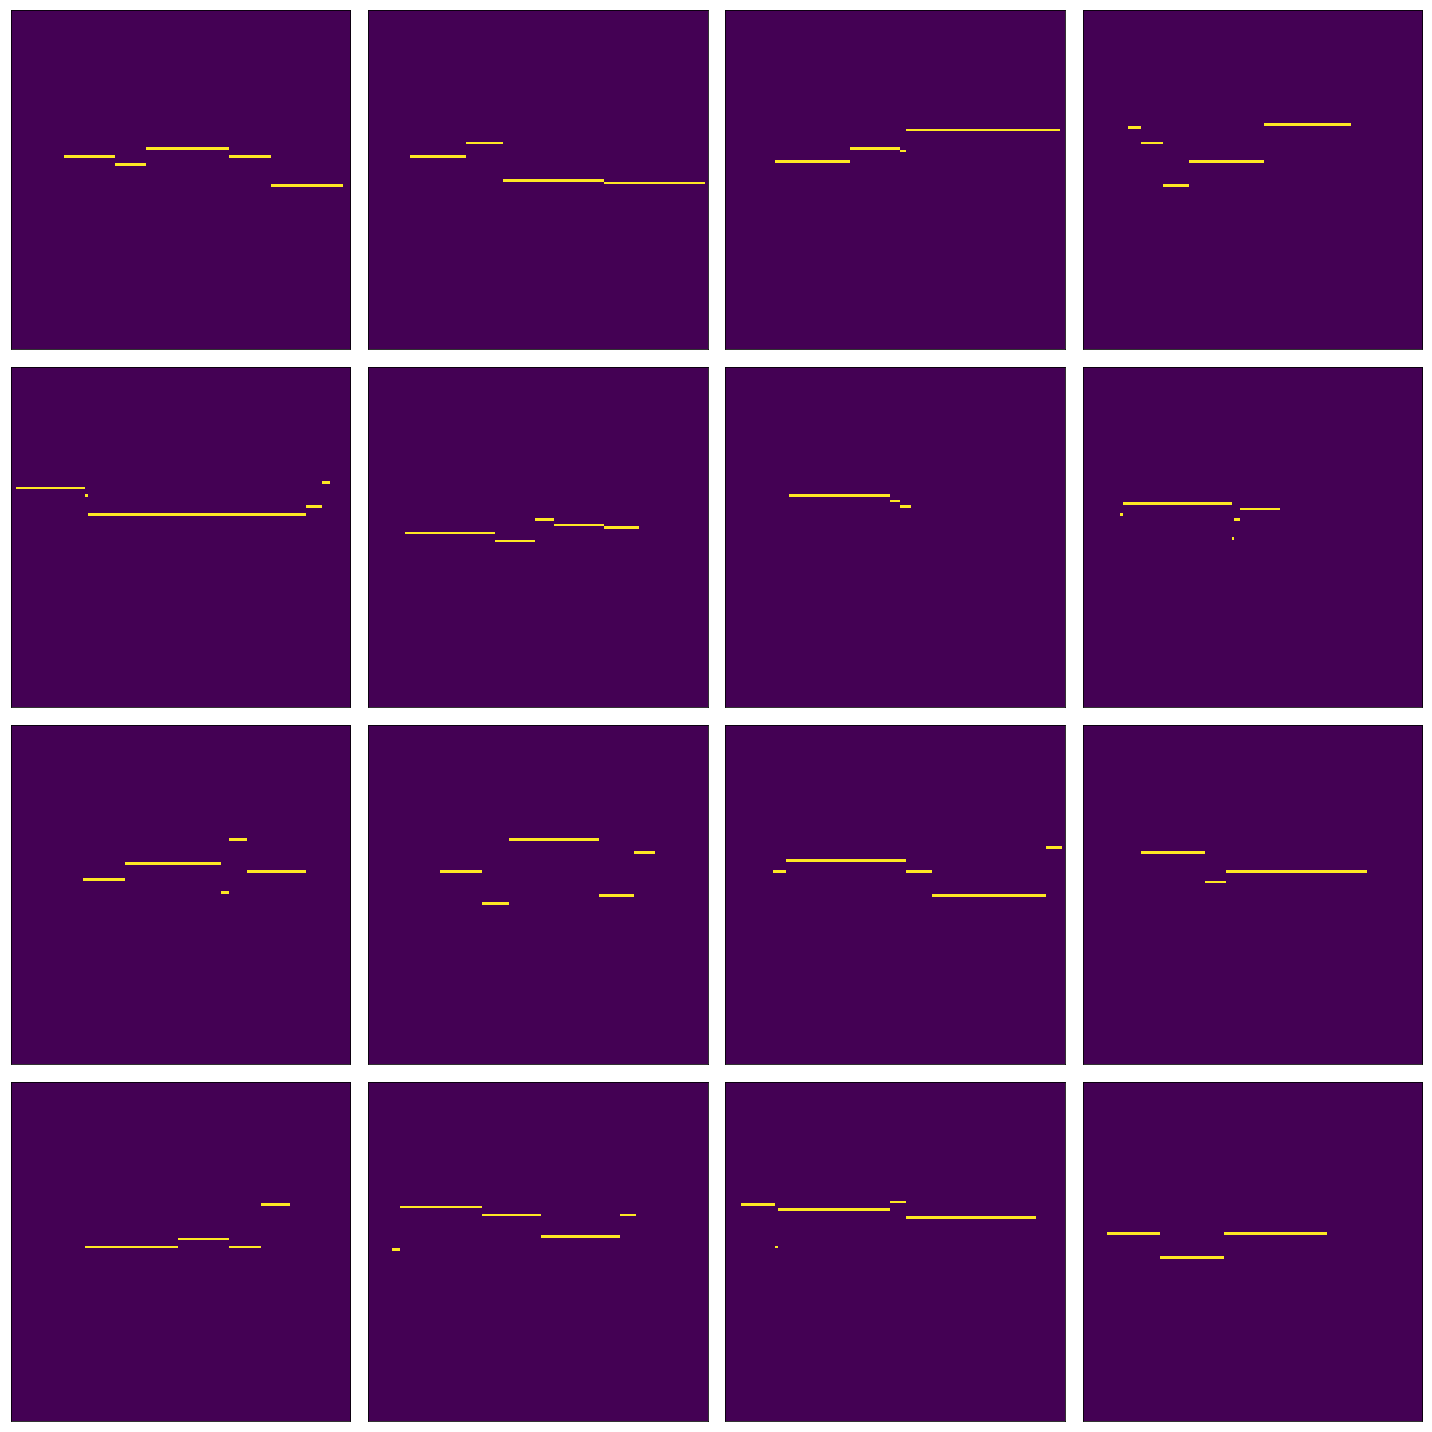

In [198]:
import matplotlib.pyplot as plt

x = multi_note_harmonic_seed(length=128, batch_size=16)

if len(x.shape) == 3:
    fig, axs = plt.subplots(nrows=x.shape[0] // 4, ncols=4, figsize=(20, 20),
                            subplot_kw={'xticks': [], 'yticks': []})
    for ax, x_ in zip(axs.flat, x):
        ax.imshow(x_.T[::-1, :])
else:
    plt.imshow(x[0].T[::-1, :])

plt.tight_layout()
plt.show()

### Generate sequence

In [ ]:
# at default 1 frame = 0.025s
SEQUENCE_LENGTH = 200

x = seed
for i in range(SEQUENCE_LENGTH):
    print(i, end=',')
    res = model.predict(x, batch_size=1)
    x = np.concatenate([x, res[np.newaxis]], axis=1)
    
res = x
res.shape

### Save to midi format

In [ ]:
res = res.round()
res = np.squeeze(res, axis=0)
res[0] = np.zeros(INPUT_SIZE)
res = np.append(res, np.zeros((1, INPUT_SIZE)), axis=0)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(res.T[::-1,:])
plt.show()

In [ ]:
# from midi_numpy.common import save_numpy_midi
from midi_numpy.numpy_to_midi import pipe_reverse as numpy2midi
from datetime import datetime

tim = str(datetime.now()).replace(' ', '_').replace(':', '_')
output_path = 'D:\\Studia\\SEM6\\biai\\projekt\\pretrained_models\\'
output_file_name = f'sample_{SEQUENCE_LENGTH}_{tim}.mid'

# save_numpy_midi(, np.squeeze(res, axis=0))
# res = np.append(res, np.zeros((1, INPUT_SIZE)))
# if len(res.shape) == 3:
#     res = np.squeeze(res, axis=0)

print(res.shape)
mid = numpy2midi(res)
for n in mid.tracks[0]:
    print(n)
# mid.save(output_path + output_file_name)